In [1]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

# Homomorphic Encrypted LeNet-1
This notebook will show a very practical example of running the famous LeNet-1 DL model directly on encrypted data.

![scheme](HE_processing.png)

## Homomorphic encryption operations
First of all, we will look at Pyfhel, a Python library which wraps SEAL, one of the most used frameworks for HE.
Pyfhel supports the BFV scheme, so, it is the one that we will use.

In [2]:
from Pyfhel import Pyfhel, PyPtxt, PyCtxt

n_mults = 6
scale_power = 26

HE = Pyfhel()
HE.contextGen(scheme='ckks', n=8192, scale=2**26, qi=[31]+ [scale_power]*n_mults +[31])
HE.keyGen()
HE.relinKeyGen()

print(HE)

<ckks Pyfhel obj at 0x7f745c252530, [pk:Y, sk:Y, rtk:-, rlk:Y, contx(n=8192, t=0, sec=128, qi=[31, 26, 26, 26, 26, 26, 26, 31], scale=67108864.0, )]>


In [3]:
c1 = HE.encrypt(0.5)
c2 = HE.encrypt(0.4)

In [4]:
p1 = HE.encode(0.1)
p2 = HE.encode(0.2)
p3 = HE.encode(0.3)

In [5]:
den = HE.encode(0.2)

In [6]:
print(c1)
print(p1)

<Pyfhel Ciphertext at 0x7f72d77d9340, scheme=ckks, size=2/2, scale_bits=26, mod_level=0>
<Pyfhel Plaintext at 0x7f72d73c3cc0, scheme=ckks, poly=?, is_ntt=Y, mod_level=0>


In [7]:
result = ( (c1 * p1) + (c2 * p2) ) + p3
print(result)

<Pyfhel Ciphertext at 0x7f72d73d0a80, scheme=ckks, size=2/2, scale_bits=26, mod_level=1>


In [8]:
result = ( (c1 * p1) + (c2 * p2) ) + p3
result = result * result
HE.relinearize(result)
HE.rescale_to_next(result)

In [9]:
result

<Pyfhel Ciphertext at 0x7f72d73c8800, scheme=ckks, size=2/3, scale_bits=26, mod_level=2>

In [10]:
HE.align_mod_n_scale(result, den)

(<Pyfhel Ciphertext at 0x7f72d73d0ec0, scheme=ckks, size=2/2, scale_bits=26, mod_level=2>,
 <Pyfhel Plaintext at 0x7f72d73d0e00, scheme=ckks, poly=?, is_ntt=Y, mod_level=2>)

In [11]:
HE.mod_switch_to_next(den)
HE.mod_switch_to_next(den)

In [12]:
result

<Pyfhel Ciphertext at 0x7f72d73c8800, scheme=ckks, size=2/3, scale_bits=26, mod_level=2>

In [13]:
den

<Pyfhel Plaintext at 0x7f72da1ae300, scheme=ckks, poly=?, is_ntt=Y, mod_level=2>

In [14]:
result * den

<Pyfhel Ciphertext at 0x7f72d4eeb1c0, scheme=ckks, size=2/2, scale_bits=52, mod_level=3>

In [15]:
# print(s.mod_level)
# print(den)

In [16]:
# f = s * den

In [17]:
a = np.array([127.15717263])
b = -2.128965182, 0.1
ctxt1 = HE.encrypt(a)
ctxt2 = HE.encode(b)

ctxtSum = ctxt1 + ctxt2
ctxtSub = ctxt1 - ctxt2
ctxtMul = ctxt1 * ctxt2

resSum = HE.decrypt(ctxtSum)
resSub = HE.decrypt(ctxtSub) 
resMul = HE.decrypt(ctxtMul)

print(f"Expected sum: {a+b}, decrypted sum: {resSum[0]}")
print(f"Expected sub: {a-b}, decrypted sum: {resSub[0]}")
print(f"Expected mul: {a*b}, decrypted sum: {resMul[0]}")

Expected sum: [125.02820745 127.25717263], decrypted sum: 125.02819805466478
Expected sub: [129.28613781 127.05717263], decrypted sum: 129.28612835901663
Expected mul: [-270.71319317   12.71571726], decrypted sum: -270.7131693169107


## LeNet-1
The LeNet-1 is a small CNN developed by LeCun et al. It is composed of 5 layers: a convolutional layer with 4 kernels of size 5x5 and tanh activation, an average pooling layer with kernel of size 2, another convolutional layer with 16 kernels of size 5x5 and tanh activation, another average pooling layer with kernel of size 2, and a fully connected layers with size 192x10. 

The highest value in the output tensor corresponds to the label LeNet-1 associated to the input image. 

For this tutorial we will use the MNIST dataset.

In [18]:
transform = transforms.ToTensor()

test_set = torchvision.datasets.MNIST(
    root = './data',
    train=False,
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=50,
    shuffle=True
)

36.9%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

80.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

14.4%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Approximating
As we know, there are some operations that cannot be performed homomorphically on encrypted values. Most notably, these operations are division and comparison. It is possible to perform only linear functions.

Consequently, in the LeNet-1 scheme we used, we can not use `tanh()`. This is because we cannot apply its non-linearities.


One of the most common approach is to replace it with a simple polynomial function, for example a square layer (which simply performs $x \rightarrow x^2$).

We define the model with all the non-linearities removed **approximated**. This model can be re-trained, and it will be ready to be used on encrypted values.

In [19]:
class Square(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 2)

lenet_1_approx = torch.load("LeNet1_Approx_single_square.pt")
# lenet_1_approx = torch.load("LeNet1_Approx_simple.pt")
lenet_1_approx.to("cpu")

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): Square()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=192, out_features=10, bias=True)
)

## Encoding
From the applicative point of view, we have two options on how we want our Torch model to run on encrypted values:
  1. Modify Torch layers code in order to be fully compatible with arrays of Pyfhel ciphertexts/encoded values;
  2. Create the code for the general blocks of LeNet-1 (convolutional layer, linear layer, square layer, flatten...)
  
Let's remember that, in order to be used with the encrypted values, also the weights of the models will have to be **encoded**. This means that each value in the weights of each layer will be encoded in a polynomial.

In [20]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

We can now use a function to "convert" a PyTorch model to a list of sequential HE-ready-to-be-used layers (`sequential`):

In [21]:
from pycrcnn.he.HE import CKKSPyfhel
from pycrcnn.model.sequential import Sequential

## Encrypted processing

Let's list the activities that we will now do:
  1. Create a PyCrCNN BFV HE context, specifiying the encryption parameters `m` (polynomial modulus degree) and `p` (plaintext modulus). Let's remember that `q` will be chosen automatically in order to guarantee a 128-bit RSA equivalent security;
  2. Convert our Torch approximated model to a list of layers able to work on matrices of encrypted values. The weights will be encoded;
  3. Encrypt an image from our testing set;
  4. Verify that the final classification result is correct.

In [23]:
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))

sample_image = images[0]
sample_label = labels[0]

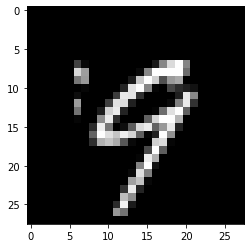

In [24]:
plt.imshow(sample_image[0], cmap='gray', interpolation='none')

In [25]:
sample_label

tensor(9)

We will create two PyCrCNN HE contexts: the one we will use to encrypt the image (`HE_Client`), and the one we will use to process the encrypted image (`HE_Server`). We will need to transfer the public key and the relinearization key in order to allow the server to compute some operations on encrypted data.

In [26]:
# La somma dei qi, in bits, ha degli upperbound
# legati al valore di n:
# 1024 -> 27
# 2048 -> 54
# 4096 -> 109
# 8192 -> 218
# 16384 -> 438
# 32768 -> 881

start_time = time.time()

n_mults = 6
n = 8192
scale_power = 25

encryption_parameters = {
    'n': n,                      # For CKKS, n/2 values can be encoded in a single ciphertext
    'scale': 2**scale_power,                 # Each multiplication grows the final scale
    'qi': [34]+ [scale_power]*n_mults +[34]  # One intermdiate for each multiplication
}

HE_Client = CKKSPyfhel(**encryption_parameters)
HE_Client.generate_keys()
HE_Client.generate_relin_keys()

public_key = HE_Client.get_public_key()
relin_key  = HE_Client.get_relin_key()


HE_Server = CKKSPyfhel(**encryption_parameters)
HE_Server.load_public_key(public_key)
HE_Server.load_relin_key(relin_key)

requested_time = round(time.time() - start_time, 2)
print(f"\nThe context generation requested {requested_time} seconds.")


The context generation requested 0.32 seconds.


Now, we create an encoded model starting from the approximated LeNet1.

In [27]:
start_time = time.time()
lenet1_approx_encoded = Sequential(HE_Server, lenet_1_approx)
requested_time = round(time.time() - start_time, 2)
print(f"\nThe model encoding requested {requested_time} seconds.")

start_time = time.time()
encrypted_image = HE_Client.encrypt_matrix(sample_image.unsqueeze(0).numpy())
requested_time = round(time.time() - start_time, 2)
print(f"\nThe image encryption requested {requested_time} seconds.")


The model encoding requested 5.15 seconds.

The image encryption requested 5.94 seconds.


In [28]:
with torch.no_grad():
    expected_output = lenet_1_approx(sample_image.unsqueeze(0))

In [29]:
start_time = time.time()
encrypted_output = lenet1_approx_encoded(encrypted_image, debug=False)
requested_time = round(time.time() - start_time, 2)
print(f"\nThe encrypted processing of one image requested {requested_time} seconds.")

start_time = time.time()
result = HE_Client.decrypt_matrix(encrypted_output)
requested_time = round(time.time() - start_time, 2)
print(f"\nThe decryption of one result requested {requested_time} seconds.")

difference = expected_output.numpy() - result

print(f"\nThe expected result was:")
print(expected_output)

print(f"\nThe actual result is: ")
print(result)

print(f"\nThe error is:")
print(difference)    


The encrypted processing of one image requested 91.18 seconds.


AttributeError: 'Pyfhel.Pyfhel.Pyfhel' object has no attribute 'decryptFracFrac'

In this case we were not able to examine the NB evolution during the computation, because in order to compute the NB we need the secret key. If we use the same PyCrCNN HE context both to encrypt and to process the data, then we will also see the evolution of the NB after each layer.